In [1]:
import os
import zipfile
import requests
import warnings
from io import BytesIO

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision import models, datasets, transforms
from torchviz import make_dot
from torchsummary import summary
from torch.utils.data import DataLoader, random_split

from PIL import Image

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tqdm import tqdm

In [4]:

# URL of the dataset
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

# Send a GET request to the URL
response = requests.get(url)

# Open the file in binary write mode and save the content
with open("kagglecatsanddogs_5340.zip", "wb") as file:
    file.write(response.content)

print("Download completed.")


Download completed.


In [5]:
# Path to the downloaded zip file
zip_file_path = "kagglecatsanddogs_5340.zip"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(".")

# Checking the contents of the extracted directory
if os.path.exists('PetImages'):
    print("Extraction successful. Contents:", os.listdir('PetImages'))
else:
    print("Extraction failed or 'PetImages' directory not found.")

Extraction successful. Contents: ['Cat', 'Dog']


In [6]:
def delete_small_files(directory, size_threshold=2048):
    """
    Delete files smaller than a specified size in a directory.

    :param directory: Path to the directory to scan for small files.
    :param size_threshold: File size threshold in bytes (default is 1024 bytes for 1KB).
    """
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)

            # Check if file size is smaller than the threshold
            if os.path.getsize(file_path) < size_threshold:
                print(f"Deleting {file_path}...")
                os.remove(file_path)

delete_small_files('PetImages')

Deleting PetImages\Cat\10392.jpg...
Deleting PetImages\Cat\10893.jpg...
Deleting PetImages\Cat\11091.jpg...
Deleting PetImages\Cat\1423.jpg...
Deleting PetImages\Cat\2433.jpg...
Deleting PetImages\Cat\3641.jpg...
Deleting PetImages\Cat\4577.jpg...
Deleting PetImages\Cat\4833.jpg...
Deleting PetImages\Cat\485.jpg...
Deleting PetImages\Cat\5257.jpg...
Deleting PetImages\Cat\5527.jpg...
Deleting PetImages\Cat\5534.jpg...
Deleting PetImages\Cat\5673.jpg...
Deleting PetImages\Cat\5954.jpg...
Deleting PetImages\Cat\596.jpg...
Deleting PetImages\Cat\6402.jpg...
Deleting PetImages\Cat\6614.jpg...
Deleting PetImages\Cat\666.jpg...
Deleting PetImages\Cat\7314.jpg...
Deleting PetImages\Cat\7487.jpg...
Deleting PetImages\Cat\7968.jpg...
Deleting PetImages\Cat\835.jpg...
Deleting PetImages\Cat\8470.jpg...
Deleting PetImages\Dog\10155.jpg...
Deleting PetImages\Dog\10385.jpg...
Deleting PetImages\Dog\10654.jpg...
Deleting PetImages\Dog\11248.jpg...
Deleting PetImages\Dog\11465.jpg...
Deleting PetImag

In [7]:
# class RobustImageFolder(datasets.ImageFolder):
#     def __getitem__(self, index):
#         # Loop to skip over corrupt images
#         while True:
#             try:
#                 path, target = self.samples[index]
#                 sample = self.loader(path)
#                 if self.transform is not None:
#                     sample = self.transform(sample)
#                 if self.target_transform is not None:
#                     target = self.target_transform(target)
#                 return sample, target
#             except (IOError, SyntaxError) as e:
#                 print(f"Corrupted image found: {path}, skipping.")
#                 index = (index + 1) % len(self.samples)
#             except UserWarning as e:
#                 warnings.warn(str(e))
#                 # Handle specific warning here, e.g., skip or use a default image
#                 print(f"Some other error: {path}, skipping.")
#                 index = (index + 1) % len(self.samples)

class RobustImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        while True:
            try:
                path, target = self.samples[index]
                sample = self.loader(path)
                if self.transform is not None:
                    sample = self.transform(sample)
                if self.target_transform is not None:
                    target = self.target_transform(target)
                return sample, target
            except Exception as e:
                print(f"Error with image {path}: {e}, skipping.")
                index = (index + 1) % len(self.samples)

In [8]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
#full_dataset = datasets.ImageFolder(root='PetImages', transform=transform)
# Load the dataset using RobustImageFolder
full_dataset = RobustImageFolder(root='PetImages', transform=transform)


# Split the dataset into training and testing sets
train_size = int(0.8 * len(full_dataset))  # 80% of the dataset for training
test_size = len(full_dataset) - train_size  # the rest for testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [9]:

# Loading a pretrained model (ResNet18) and modifying it for binary classification
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Modifying for 2 classes: Cats and Dogs

# Checking if GPU is available and moving the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
print(model)

cuda:0
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T

In [10]:
# 'transform' is our transformation pipeline
resize_transform = [t for t in transform.transforms if isinstance(t, transforms.Resize)]
if resize_transform:
    input_size = resize_transform[0].size
else:
    input_size = (224, 224)  # Default size or a fallback option

# Convert the size to the format expected by torchsummary
input_shape = (3, input_size[0], input_size[1])

# Using torchsummary
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [12]:
class ModifiedResNet(nn.Module):
    def __init__(self):
        super(ModifiedResNet, self).__init__()
        # Load a pre-trained ResNet
        original_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Everything except the last layer
        self.features = nn.Sequential(*list(original_model.children())[:-2])

        # Flatten operation
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  # Final layer for binary classification

    def forward(self, x):
        # Apply the feature extractor
        x = self.features(x)

        # Flatten the output
        x = self.flatten(x)

        # Apply the fully connected layers with ReLU activations
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)

        return x

    def unfreeze(self):
        # Unfreeze all layers
        for param in self.parameters():
            param.requires_grad = True


In [13]:
# Instantiate the modified model
modified_model = ModifiedResNet()

# Check if GPU is available and move the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
modified_model = modified_model.to(device)

# Now you can print the summary. Ensure the input tensor is also on the correct device.
# The input shape must match the input that the network expects.
input_shape = (3, 224, 224)  # This is the shape for a single image (channels, height, width)
summary(modified_model, input_shape, device=device.type)  # Add batch size in the shape if necessary


cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [

In [14]:
## Assuming 'model' is your PyTorch model
## Create a dummy input tensor appropriate for your model
#dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Adjust the size as per your model's requirement
#
## Forward pass through the model
#out = model(dummy_input)
#
## Create the visualization
#dot = make_dot(out, params=dict(list(model.named_parameters()) + [('input', dummy_input)]))
#
## Save or render the visualization
#dot.render('model_graph', format='png')  # This will save the graph as a PNG file


In [15]:
model = modified_model

In [16]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = Adam(model.parameters(), lr=0.001)  


In [17]:

# Training the model
#for epoch in range(2):  # Looping over the dataset multiple times
#    running_loss = 0.0
#    for i, data in enumerate(train_loader, 0):
#        inputs, labels = data[0].to(device), data[1].to(device)
#
#        optimizer.zero_grad()
#
#        outputs = model(inputs)
#        loss = criterion(outputs, labels)
#        loss.backward()
#        optimizer.step()
#
#        running_loss += loss.item()
#        if i % 100 == 99:    # Print every 100 mini-batches
#            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
#            running_loss = 0.0
#
#print('Finished Training')


Epoch 1/10 [Training]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [02:30<00:00,  1.04it/s]


Epoch 1/10 Training - Accuracy: 0.9365, Precision: 0.9391, Recall: 0.9338


Epoch 1/10 [Testing]:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 33/39 [00:29<00:05,  1.12it/s]C:\Users\francji1\OneDrive\gpu_test\venv\Lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/10 Testing - Accuracy: 0.9701, Precision: 0.9762, Recall: 0.9632


Epoch 2/10 [Training]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [01:16<00:00,  2.03it/s]


Epoch 2/10 Training - Accuracy: 0.9756, Precision: 0.9762, Recall: 0.9752


Epoch 2/10 [Testing]:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 33/39 [00:13<00:02,  2.37it/s]C:\Users\francji1\OneDrive\gpu_test\venv\Lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2/10 Testing - Accuracy: 0.9583, Precision: 0.9817, Recall: 0.9332


Epoch 3/10 [Training]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [01:15<00:00,  2.06it/s]


Epoch 3/10 Training - Accuracy: 0.9808, Precision: 0.9798, Recall: 0.9819


Epoch 3/10 [Testing]:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 33/39 [00:13<00:02,  2.35it/s]C:\Users\francji1\OneDrive\gpu_test\venv\Lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 3/10 Testing - Accuracy: 0.9503, Precision: 0.9916, Recall: 0.9073


Epoch 4/10 [Training]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [01:16<00:00,  2.03it/s]


Epoch 4/10 Training - Accuracy: 0.9831, Precision: 0.9830, Recall: 0.9833


Epoch 4/10 [Testing]:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 33/39 [00:13<00:02,  2.33it/s]C:\Users\francji1\OneDrive\gpu_test\venv\Lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 4/10 Testing - Accuracy: 0.9591, Precision: 0.9813, Recall: 0.9352


Epoch 5/10 [Training]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [01:13<00:00,  2.12it/s]


Epoch 5/10 Training - Accuracy: 0.9860, Precision: 0.9861, Recall: 0.9859


Epoch 5/10 [Testing]:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 33/39 [00:13<00:02,  2.30it/s]C:\Users\francji1\OneDrive\gpu_test\venv\Lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 5/10 Testing - Accuracy: 0.9709, Precision: 0.9663, Recall: 0.9753


Epoch 6/10 [Training]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [01:12<00:00,  2.16it/s]


Epoch 6/10 Training - Accuracy: 0.9885, Precision: 0.9881, Recall: 0.9889


Epoch 6/10 [Testing]:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 33/39 [00:13<00:02,  2.33it/s]C:\Users\francji1\OneDrive\gpu_test\venv\Lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 6/10 Testing - Accuracy: 0.9653, Precision: 0.9881, Recall: 0.9413


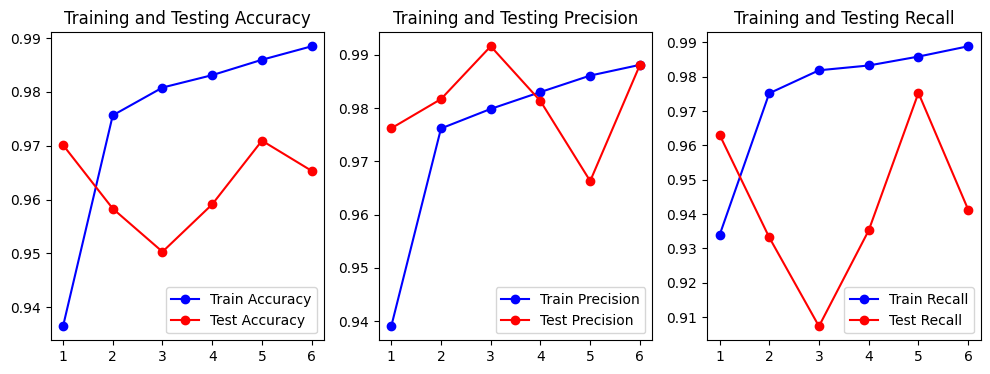

In [18]:
train_accuracies, train_precisions, train_recalls = [], [], []
test_accuracies, test_precisions, test_recalls = [], [], []
n_epochs = 6

for epoch in range(n_epochs):
    # Variables to store predictions and labels for the training dataset
    train_labels = []
    train_predictions = []

    # Training loop with progress bar
    model.train()  # Set the model to training mode
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Training]')
    for inputs, labels in train_progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_predictions.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate and print training metrics
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_precision = precision_score(train_labels, train_predictions, average='binary')
    train_recall = recall_score(train_labels, train_predictions, average='binary')
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    print(f'Epoch {epoch+1}/{n_epochs} Training - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}')

    # Variables to store predictions and labels for the testing dataset
    test_labels = []
    test_predictions = []

    # Testing loop with progress bar
    model.eval()  # Set the model to evaluation mode
    test_progress_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{10} [Testing]', leave=False)
    with torch.no_grad():
        for inputs, labels in test_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Calculate and print testing metrics
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_precision = precision_score(test_labels, test_predictions, average='binary')
    test_recall = recall_score(test_labels, test_predictions, average='binary')
    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    print(f'Epoch {epoch+1}/{n_epochs} Testing - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

# Plotting the metrics
epochs = range(1, n_epochs+1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, test_accuracies, 'ro-', label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_precisions, 'bo-', label='Train Precision')
plt.plot(epochs, test_precisions, 'ro-', label='Test Precision')
plt.title('Training and Testing Precision')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_recalls, 'bo-', label='Train Recall')
plt.plot(epochs, test_recalls, 'ro-', label='Test Recall')
plt.title('Training and Testing Recall')
plt.legend()

plt.show()


In [22]:
import os
import nbformat

def convert_notebook_to_script(script_name):
    # Get the current working directory
    notebook_dir = os.getcwd()
    
    # Assuming the notebook file is in the same directory
    notebook_path = os.path.join(notebook_dir, 'transfer_learning_catsdogs.ipynb')
    script_path = os.path.join(notebook_dir, script_name)

    with open(notebook_path, 'r', encoding='utf-8') as nb_file:
        nb_contents = nb_file.read()

    notebook = nbformat.reads(nb_contents, as_version=4)

    with open(script_path, 'w', encoding='utf-8') as script_file:
        for cell in notebook.cells:
            if cell.cell_type == 'code':
                script_file.write(cell.source + '\n\n')

# Call the function with your desired script name
convert_notebook_to_script('transfer_learning_catsdogs.py')